<a href="https://colab.research.google.com/github/pachterlab/GVFP_2021/blob/dev/loom_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Interpretable and tractable models of transcriptional noise for the rational design of single-molecule quantification experiments"
## by Gennady Gorin<sup>*</sup>, John Vastola<sup>*</sup>, Meichen Fang, and Lior Pachter
### <sup>*</sup> These authors contributed equally to this work.
# Companion notebook for Figure 3 

This notebook is self-contained, and generates the panels used in Figure 3 (albeit mostly without axis labels). There are five panels:

**a**. Log Bayes factors across space of qualitative regimes

**b**. Slice of a. to show distinguishability as a function of the gain ratio

**c**. Distinguishability of two models versus trivial models as function of gain ratio

**d**. Example parameter set for which $\Gamma$-OU and CIR are very different

**e**. Bayesian parameter inference

The sections of this notebook, apart from the first (which contains relevant functions), correspond to the above panels.

In [ ]:
import time as ti
tstart = ti.time()


In [ ]:
# Scientific computing imports
import numpy as np
from numpy.fft import irfftn
from numpy.random import choice
from scipy.stats import rv_discrete, poisson, nbinom, gaussian_kde
import matplotlib.pyplot as plt

# PyMC3-related imports
import pymc3 as pm
import theano.tensor as tt

# Plotting
import matplotlib.pyplot as plt
import arviz as az
import matplotlib as mpl


In [ ]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
!mkdir -p results

------------------------------------------------

In [ ]:
!git clone --branch dev https://github.com/pachterlab/GVFP_2021.git

Cloning into 'GVFP_2021'...
remote: Enumerating objects: 501, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 501 (delta 27), reused 32 (delta 22), pack-reused 462
Receiving objects: 100% (501/501), 197.81 MiB | 25.57 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [ ]:
!mv GVFP_2021/* .

In [ ]:
! mv loom/* .

In [ ]:
!cat allen_C01_glu.tar.gz.001 allen_C01_glu.tar.gz.002 | tar -xzv


allen_C01_glu.loom


In [ ]:
!pip install loompy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.8 MB 5.1 MB/s 
  Created wheel for loompy: filename=loompy-3.0.7-py3-none-any.whl size=52040 sha256=609e756dcfc2904762da4f6c42c3e00d93d77bad004c547a6d5fcedcba314f56
  Stored in directory: /root/.cache/pip/wheels/48/36/9f/eb3377d4a7423b96105b6667d36c3faa49ee73b96d8cab80b3
Successfully built loompy


In [ ]:
import loompy as lp

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


## Functions

### General-purpose functions

In [ ]:
# Utility function that converts between (x, y) qualitative regime coordinates to original parameters.
def convert_xy_to_params(x, y, beta, gamma, K_avg):
    kappa = (beta + gamma)*(x/(1-x))
    a_over_th = 1/y - 1
    theta = np.sqrt(kappa*K_avg/a_over_th)
    a = K_avg*kappa/theta
    return a, kappa, theta


# Sample from flattened 2D probability distribution p. 
# mx = [mx0, mx1] is the shape of the 2D domain we're sampling.
def sample_from_p(mx, num_data_points, p_flat):
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')    # get grid of possible values
    x_choices = np.arange(np.prod(mx))                 # represent each grid point as a point in a 1D vector
    
    samples = choice(x_choices, size=num_data_points, replace=True, p=p_flat)
    d_N, d_M = X_N.flatten()[samples], X_M.flatten()[samples]    
    return d_N, d_M


# Get maximum of a 2D array
def get_2D_max(array):
    return np.unravel_index(array.argmax(), array.shape)


# Get KDE for smooth-looking heatmaps.
def get_2D_KDE(x_stats, y_stats, x_min=0, x_max=1, y_min=0, y_max=1):
    num_pts = 100                          # hyperparameter
    x_arg = np.linspace(x_min, x_max, num_pts)
    y_arg = np.linspace(y_min, y_max, num_pts)

    X_arg, Y_arg = np.meshgrid(x_arg, y_arg, indexing='ij')      # grid of points      X0, X1

 
    positions = np.vstack([X_arg.ravel(), Y_arg.ravel()])
    kernel = gaussian_kde([x_stats, y_stats])
    KDE = np.reshape(kernel(positions).T, X_arg.shape)
    return KDE, x_arg, y_arg
    

### Trivial model (constitutive/Poisson and mixture/NB) likelihood functions

In [ ]:
# Constitutive model likelihood function.
def get_Poiss_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    K_avg = (a*theta)/kappa
    mu_N, mu_M = K_avg/beta, K_avg/gamma
    
    x_N, x_M = np.arange(mx[0]), np.arange(mx[1])
    X_N, X_M = np.meshgrid(x_N, x_M, indexing='ij')
    
    return poisson.pmf(X_N, mu_N)*poisson.pmf(X_M, mu_M)


# Mixture model likelihood function.
def get_NB_2sp(mx, params):
    beta, gamma, a, kappa, theta = params 
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = np.exp(- (a/kappa)*np.log(1 - theta*(g[0]/beta + g[1]/gamma)))
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss

### $\Gamma$-OU likelihood functions

In [ ]:
# Get 2 species GOU generating function using ODE method
def get_gf_GOU_2sp_ODE(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 1, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1
    

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    return gf


# Get Pss for 2 species GOU model via ODE method
def get_GOU_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_GOU_2sp_ODE(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of GOU model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_GOU(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_GOU_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result


# Combines the above functions into one to reduce overhead associated with Python function calls.
# Helpful when doing expensive posterior sampling (since many likelihood function calls are required).
def ll_GOU2(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    beta_0 = beta
    beta_1 = gamma
    
    c0 = (g[0]) + (beta_0/(beta_1 - beta_0))*(g[1])       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g[1])   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
    
    t_array = np.linspace(0, t_max, num_tsteps+1)
    t_array = t_array.reshape((1, num_tsteps + 1))
    
    q = np.zeros((c0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    c0 = c0.reshape((c0.shape[0],1))
    c1 = c1.reshape((c1.shape[0],1))
    q0 = theta*c0*(np.exp(-beta_0*t_array) - np.exp(-kappa*t_array))/(kappa - beta_0) 
    q1 = theta*c1*(np.exp(-beta_1*t_array) - np.exp(-kappa*t_array))/(kappa - beta_1)
    q = q0 + q1

    integrand = q/(1-q)
    integral = np.trapz(integrand, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp( a*integral)               # get generating function
    
    gf = gf.reshape(tuple(half))
    
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

### CIR likelihood functions

In [ ]:
# ODE for 2 species CIR model
def f_2sp(q, t, c0, c1, params):
    beta_0, beta_1, a, kappa, theta = params
    result = - kappa*q + theta*q*q + kappa*( c0*np.exp(-beta_0*t) + c1*np.exp(-beta_1*t)  ) 
    return result


# Vectorized RK4 implementation for 2 species CIR model
def RK4_2sp(q, f, t, c0, c1, step_size, param):
    j1 = f(q, t, c0, c1, param)
    j2 = f(q + (step_size/2)*j1, t + (step_size/2), c0, c1, param)   
    j3 = f(q + (step_size/2)*j2, t + (step_size/2), c0, c1, param)   
    j4 = f(q + (step_size)*j3, t + (step_size), c0, c1, param)  
    
    q_new = q + (step_size/6)*(j1 + 2*j2 + 2*j3 + j4)
    return q_new


# Get 2 species CIR generating function using ODE method
def get_gf_CIR_2sp(g0, g1, params):
    beta_0, beta_1, a, kappa, theta = params     # get parameters
    
    c0 = (g0) + (beta_0/(beta_1 - beta_0))*(g1)       #  relevant linear combinations of g_i
    c1 = - (beta_0/(beta_1 - beta_0))*(g1)   
    
    min_fudge, max_fudge = 0.5, 10                                     # Determine integration time scale / length
    dt = np.min([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*min_fudge
    t_max = np.max([1/kappa, 1/theta, 1/beta_0, 1/beta_1])*max_fudge
    num_tsteps = int(np.ceil(t_max/dt))
     
    q = np.zeros((g0.shape[0], num_tsteps + 1), dtype=np.complex64)    # initialize array to store ODE
    
    # Solve ODE using RK4 method 
    for i in range(0, num_tsteps):
        t = i*dt
        q[:,i+1] = RK4_2sp(q[:,i], f_2sp, t, c0, c1, dt, params)
        
    integral = np.trapz(q, dx=dt, axis=1)     # integrate ODE solution
    gf = np.exp((a*theta/kappa)*integral)               # get generating function
    return gf


# Get Pss for 2 species CIR model via ODE method
def get_CIR_2sp(mx, params):
    # Get generating function argument
    u = []
    half = mx[:]
    half[-1] = mx[-1]//2 + 1
    for i in range(len(mx)):
        l = np.arange(half[i])
        u_ = np.exp(-2j*np.pi*l/mx[i])-1
        u.append(u_)
    g = np.meshgrid(*[u_ for u_ in u], indexing='ij')
    for i in range(len(mx)):
        g[i] = g[i].flatten()
    
    # Get generating function
    gf = get_gf_CIR_2sp(g[0], g[1], params)                    
    gf = gf.reshape(tuple(half))
                              
    Pss = irfftn(gf, s=mx)                        # Get Pss by inverse fast Fourier transform
    Pss = np.abs(Pss)/np.sum(np.abs(Pss))           # Normalize
    return Pss


# Log likelihood of CIR model given data. Uses (x,y) as input instead of (kappa, theta).
def ll_CIR(phi, const, mx, data):
    # Get parameters
    x, y = phi
    beta, gamma, K_avg = const
    
    # Convert from (x, y) to original parameters
    a, kappa, theta = convert_xy_to_params(x, y, beta, gamma, K_avg)
    params = [beta, gamma, a, kappa, theta]
    
    Pss = get_CIR_2sp(mx, params)    # Compute Pss

    lp = np.log(Pss)
    result = np.sum(lp[data])
    return result

### Bayes factor functions

In [ ]:
# Generates synthetic data (either CIR or GOU) and computes log Bayes factor (e.g. P(CIR)/P(GOU))).
# Does this averaged over many trials (num_trials).
# Does this assuming different numbers of data points (e.g. num_data_points = [100, 200, 1000]). 
def log_bayes_factor_avg(model, num_data_points, num_trials, mx, params):
    
    # Initialize log BF arrays 
    num_kinds = len(num_data_points) 
    log_bf_joint = np.zeros((num_kinds, num_trials))
    log_bf_nascent = np.zeros((num_kinds, num_trials))
    log_bf_mature = np.zeros((num_kinds, num_trials))
    
    
    # Get Pss for each model given this parameter set
    if model=='CIR':
        pss = get_CIR_2sp(mx, params)
        pss_other = get_GOU_2sp(mx, params)
    elif model=='GOU':
        pss = get_GOU_2sp(mx, params)
        pss_other = get_CIR_2sp(mx, params)
    p_flat = pss.flatten()
    
    
    # Get fake data
    for r in range(0, num_kinds):
        for t in range(0, num_trials):
            
            # Sample nascent and mature counts
            d_N, d_M = sample_from_p(mx, num_data_points[r], p_flat)

            # Log-likelihood functions
            lp = np.log10(pss)    # shape: x_N_domain by x_M_domain
            lp_nascent = np.log10(np.sum(pss, axis=1))
            lp_mature = np.log10(np.sum(pss, axis=0))

            lp_other = np.log10(pss_other)
            lp_other_nascent = np.log10(np.sum(pss_other, axis=1))
            lp_other_mature = np.log10(np.sum(pss_other, axis=0))

            # Log-likelihoods given data
            ll_joint = np.sum(lp[d_N, d_M])
            ll_nascent = np.sum(lp_nascent[d_N])
            ll_mature = np.sum(lp_mature[d_M])

            ll_other_joint = np.sum(lp_other[d_N, d_M])
            ll_other_nascent = np.sum(lp_other_nascent[d_N]) 
            ll_other_mature = np.sum(lp_other_mature[d_M])

            # Bayes factor
            log_bf_joint[r,t] = ll_joint - ll_other_joint
            log_bf_nascent[r,t] = ll_nascent - ll_other_nascent
            log_bf_mature[r,t] = ll_mature - ll_other_mature
                          
        log_bf_joint_avg = np.mean(log_bf_joint, axis=1)
        log_bf_nascent_avg = np.mean(log_bf_nascent, axis=1)
        log_bf_mature_avg = np.mean(log_bf_mature, axis=1)
    
    return log_bf_joint_avg, log_bf_nascent_avg, log_bf_mature_avg

In [ ]:
# Compute averaged log Bayes factors for GOU vs Poisson, GOU vs NB, CIR vs Poisson, and CIR vs NB.
def log_bayes_factor_avg_null(num_data_points, num_trials, mx, params):
    
    # Get Pss for each model given this parameter set
    pss_CIR = get_CIR_2sp(mx, params)
    pss_GOU = get_GOU_2sp(mx, params)
    pss_Poiss = get_Poiss_2sp(mx, params)
    pss_NB = get_NB_2sp(mx, params)
    
    # Initialize log BF arrays
    log_bf_CIR_vs_Poiss, log_bf_CIR_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    log_bf_GOU_vs_Poiss, log_bf_GOU_vs_NB = np.zeros(num_trials), np.zeros(num_trials)
    
    for t in range(0, num_trials):
        
        # Get fake data
        d_GOU_N, d_GOU_M = sample_from_p(mx, num_data_points, pss_GOU.flatten())
        d_CIR_N, d_CIR_M = sample_from_p(mx, num_data_points, pss_CIR.flatten())


        # Log-likelihood functions
        lp_CIR = np.log10(pss_CIR)    # shape: mx[0] by mx[1]
        lp_GOU = np.log10(pss_GOU)  
        lp_Poiss = np.log10(pss_Poiss) 
        lp_NB = np.log10(pss_NB) 


        # Log-likelihoods given data
        log_bf_CIR_vs_Poiss[t] = np.sum(lp_CIR[d_CIR_N, d_CIR_M]) - np.sum(lp_Poiss[d_CIR_N, d_CIR_M]) 
        log_bf_CIR_vs_NB[t] = np.sum(lp_CIR[d_CIR_N, d_CIR_M]) - np.sum(lp_NB[d_CIR_N, d_CIR_M]) 

        log_bf_GOU_vs_Poiss[t] = np.sum(lp_GOU[d_GOU_N, d_GOU_M]) - np.sum(lp_Poiss[d_GOU_N, d_GOU_M]) 
        log_bf_GOU_vs_NB[t] = np.sum(lp_GOU[d_GOU_N, d_GOU_M]) - np.sum(lp_NB[d_GOU_N, d_GOU_M]) 
        
    log_bf_CIR_vs_Poiss_avg = np.mean(log_bf_CIR_vs_Poiss)
    log_bf_CIR_vs_NB_avg = np.mean(log_bf_CIR_vs_NB)
    log_bf_GOU_vs_Poiss_avg = np.mean(log_bf_GOU_vs_Poiss)
    log_bf_GOU_vs_NB_avg = np.mean(log_bf_GOU_vs_NB)

    
    return log_bf_CIR_vs_Poiss_avg, log_bf_CIR_vs_NB_avg, log_bf_GOU_vs_Poiss_avg, log_bf_GOU_vs_NB_avg

### Bayesian parameter recovery functions

In [ ]:
# This class is necessary for interfacing with PymC3.

class LogLike(tt.Op):
    
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, const, mx, data, likelihood):
        
        # add inputs as class attributes
        self.const = const
        self.mx = mx
        self.data = data
        self.likelihood = likelihood
        
    def perform(self, node, inputs, outputs):
        
        phi, = inputs # this contains parmeters
        logl = self.likelihood(phi, self.const, self.mx, self.data) # calls the log-likelihood function
        outputs[0][0] = np.array(logl) # output the log-likelihood

In [ ]:
# This function gets parameter posteriors via non-gradient-based sampling.
def get_parameter_posteriors(string_ID, const, mx, data, ll_func, draws_, tune_, chains_):
    
    # Parameter bounds
    epsilon = 0.005
    x_min, x_max = epsilon, 1-epsilon
    y_min, y_max = epsilon, 1-epsilon
    
    # Define log likelihood
    logl_op = LogLike(const, mx, data, ll_func)
    def logl_fun(phi):
        return logl_op(phi)
    
    # Define PyMC3 model
    model = pm.Model()
    with model:
        # Priors
        x_ = pm.Uniform('x', lower=x_min, upper=x_max)
        y_ = pm.Uniform('y', lower=y_min, upper=y_max)

        phi = tt.as_tensor_variable([x_, y_])

        # Likelihood
        pm.Potential('likelihood', logl_fun(phi))
        
        
    # Run PyMC3 model
    start_time = ti.time()
    with model:
        step = pm.DEMetropolisZ(tune = None)
        trace = pm.sample(draws = draws_, tune = tune_, step = step, chains = chains_, cores = 1)
    print("--- %s seconds ---" % (ti.time() - start_time))
        
    # Plot and save trace
    with model:
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        fig.savefig("results/pymc3_raw_"+string_ID+".png", bbox_inches='tight')
        fig.savefig("results/pymc3_raw_"+string_ID+".pdf", bbox_inches='tight')
        
    x_stats, y_stats = trace['x'], trace['y']
    return trace, x_stats, y_stats

In [ ]:
# This function analyzes and plots the posterior samples.
def analyze_posteriors(string_ID, x_stats, y_stats, params_true, loc=True, k_max=0, th_max=0):
    
    # True parameters
    # beta, gamma, a_true, kappa_true, theta_true = params_true
    # x_true, y_true = (kappa_true)/(kappa_true + beta + gamma), (theta_true)/(theta_true + a_true)
   

    # Get statistics in terms of kappa and theta
    a_stats, kappa_stats, theta_stats = convert_xy_to_params(x_stats, y_stats, beta, gamma, K_avg)

    
    # KDEs
    KDE_xy, x_arg, y_arg = get_2D_KDE(x_stats, y_stats, 0, 1, 0, 1)
    if k_max==0:
        k_max = np.max(kappa_stats)
    if th_max==0:
        th_max = np.max(theta_stats)
    KDE_kth, k_arg, th_arg = get_2D_KDE(kappa_stats, theta_stats, 0, k_max, 0, th_max)
    
    KDE_x = np.sum(KDE_xy, axis=1)
    KDE_x = KDE_x/np.trapz(KDE_x, x=x_arg)
    KDE_y = np.sum(KDE_xy, axis=0)
    KDE_y = KDE_y/np.trapz(KDE_y, x=y_arg)
    
    KDE_k = np.sum(KDE_kth, axis=1)
    KDE_k = KDE_k/np.trapz(KDE_k, x=k_arg)
    KDE_th = np.sum(KDE_kth, axis=0)
    KDE_th = KDE_th/np.trapz(KDE_th, x=th_arg)
    
    # Summary statistics
    x_avg, y_avg = np.mean(x_stats), np.mean(y_stats)    # posterior means
    i, j = get_2D_max(KDE_xy)
    x_map, y_map = x_arg[i], y_arg[j]
    
    k_avg, th_avg = np.mean(kappa_stats), np.mean(theta_stats)    # posterior means
    i, j = get_2D_max(KDE_kth)
    k_map, th_map = k_arg[i], th_arg[j]
    
    
    
    
    print("Plotting histograms in terms of (x,y)...")
    vals, _,  _ = plt.hist(x_stats, alpha=0.5, density=True)
    # plt.plot(x_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(x_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(x_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(x_arg, KDE_x, color='black')
    plt.xlabel('$\\kappa/(\\kappa + \\beta + \\gamma)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_x_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_x_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(y_stats, alpha=0.5, density=True)
    # plt.plot(y_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(y_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(y_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(y_arg, KDE_y, color='black')
    plt.xlabel('$\\theta/(\\theta + a)$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_y_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_y_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    
    print("Plotting histograms in terms of (kappa, theta)...")
    vals, _,  _ = plt.hist(kappa_stats, alpha=0.5, density=True)
    # plt.plot(kappa_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(k_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(k_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(k_arg, KDE_k, color='black')
    plt.xlabel('$\\kappa$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_kappa_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_kappa_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()

    vals, _, _ = plt.hist(theta_stats, alpha=0.5, density=True)
    # plt.plot(theta_true*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='black', linewidth=2, label='true')
    plt.plot(th_avg*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='red', linewidth=2, label='avg')
    plt.plot(th_map*np.ones(10), np.linspace(0, np.max(vals), 10), linestyle='--', color='blue', linewidth=2, label='MAP')
    plt.plot(th_arg, KDE_th, color='black')
    plt.xlabel('$\\theta$', fontsize=30)
    plt.ylabel('Probability', fontsize=30)
    plt.legend(fontsize=20)
    plt.savefig("results/post_marg_theta_"+string_ID+".png", bbox_inches='tight')
    plt.savefig("results/post_marg_theta_"+string_ID+".pdf", bbox_inches='tight')
    plt.show()
    
    s= mpl.rcParams['lines.markersize']**2
    newsize=3*s
    
    print("Plotting 2D heatmap in terms of (x, y)...")
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(x_map, y_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(x_avg, y_avg, color='red', label='avg', s=newsize, edgecolor='white')
    # ax.scatter(x_true, y_true, color='black', label='true', s=newsize, edgecolor='white')
    ax.imshow(np.transpose(KDE_xy), origin='lower', extent=[0, 1, 0, 1])

    if loc==True:
        plt.legend(fontsize=18, framealpha=1)
    plt.savefig('results/post_2D_xy_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_xy_'+string_ID+'.png', bbox_inches='tight')

    plt.show()
    
    
    
    
        
    print("Plotting 2D heatmap in terms of (kappa, theta)...")
    w1 = 60
    w2 = 60
    
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    ax.scatter(k_map, th_map, color='blue', label='MAP', s=newsize, edgecolor='white')
    ax.scatter(k_avg, th_avg, color='red', label='avg', s=newsize, edgecolor='white')
    # ax.scatter(kappa_true, theta_true, color='black', label='true', s=newsize, edgecolor='white')
    ax.imshow( np.transpose(KDE_kth[:w1,:w2]), origin='lower', extent=[0, k_arg[w1], 0, th_arg[w2]], aspect='auto')

    plt.savefig('results/post_2D_kth_'+string_ID+'.pdf', bbox_inches='tight')
    plt.savefig('results/post_2D_kth_'+string_ID+'.png', bbox_inches='tight')

    plt.show()

    
    
    return

------------------------------------------

## Panel E: Parameter recovery

### Overdispersed/typical case

**Pull in some real data!** It's happening! We're doing real statistics!

In [ ]:
with lp.connect('./allen_C01_glu.loom') as ds:
    S = ds.layers['spliced'][:]
    U = ds.layers['unspliced'][:]
    gene_names = ds.ra['gene_name']
    nCells = len(ds.ca['barcode'])


In [ ]:
i = np.where(gene_names=='Cox6b1')[0][0]

In [ ]:
d_M = S[i].astype(int)
d_N = U[i].astype(int)
data = [d_N, d_M]

Plot samples and true distribution.

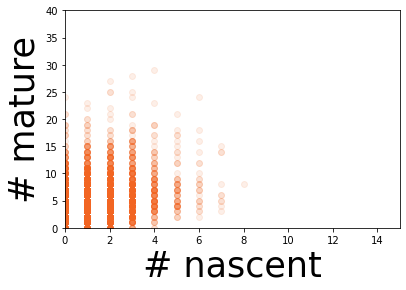

In [ ]:
w = 20

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(d_N, d_M, alpha=0.1, color=(242/255,101/255,34/255))
#ax.set_title('True', fontsize=35)
#ax.imshow(np.transpose(Pss[:w,:w]), origin='lower', alpha=0.8)
ax.set_xlim(0, 15)
ax.set_ylim(0, 40)
ax.set_xlabel('# nascent', fontsize=35)
ax.set_ylabel('# mature', fontsize=35)
plt.savefig('results/true_scatter_overdisp.png', bbox_inches='tight')
plt.savefig('results/true_scatter_overdisp.pdf', bbox_inches='tight')
plt.show()

In [ ]:
mx = [15,40]
K_avg = 1
beta = K_avg/d_N.mean()
gamma = K_avg/d_M.mean()
const = [beta, gamma, K_avg]

Run for GOU

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [y, x]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:127: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
Sampling 1 chain for 600 tune and 2_000 draw iterations (600 + 2_000 draws total) took 101 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


--- 112.52488207817078 seconds ---


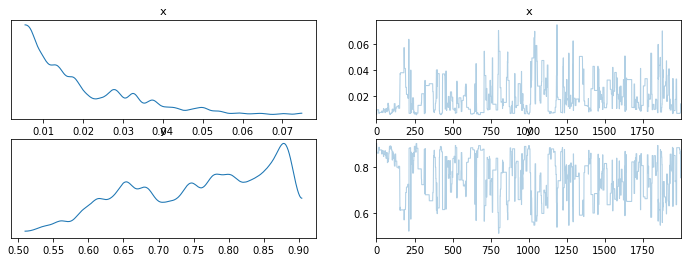

In [ ]:
string_ID = "overdispersed" 
trace, x_stats, y_stats = (
     get_parameter_posteriors(string_ID, const, mx, data, ll_func=ll_GOU2, draws_=2000, tune_=600, chains_=1) )

Get histograms.

In [ ]:
a, kappa, theta = convert_xy_to_params(x_stats.mean(), y_stats.mean(), beta, gamma, K_avg)

In [ ]:
y_stats

array([0.90440198, 0.90440198, 0.8665057 , ..., 0.86815876, 0.75322246,
       0.86278933])

Plotting histograms in terms of (x,y)...


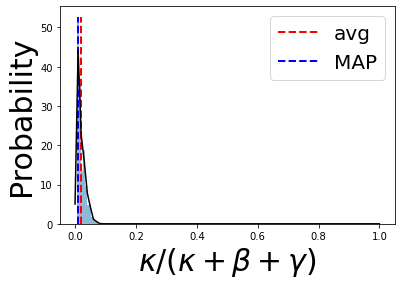

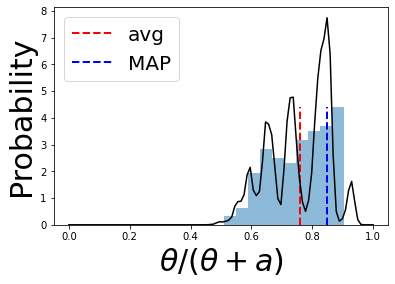

Plotting histograms in terms of (kappa, theta)...


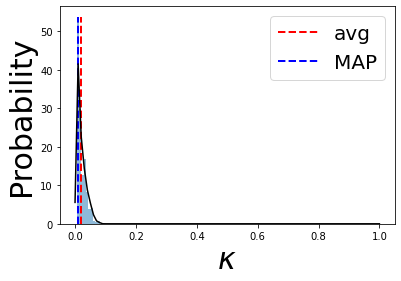

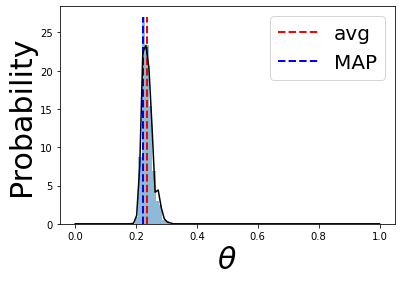

Plotting 2D heatmap in terms of (x, y)...


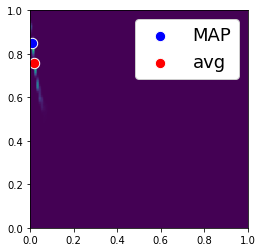

Plotting 2D heatmap in terms of (kappa, theta)...


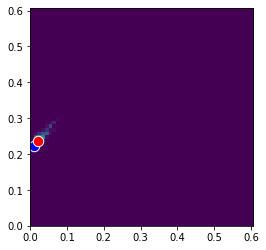

In [ ]:
loc = True
k_max = 1
th_max = 1
analyze_posteriors(string_ID, x_stats, y_stats, [], loc, k_max, th_max)

In [ ]:

params = [beta, gamma, a, kappa, theta]
Pss = get_GOU_2sp(mx, params)

In [ ]:
-np.log(Pss[data]).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


21292.99913091565

Run for CIR


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Sequential sampling (1 chains in 1 job)
DEMetropolisZ: [y, x]


Sampling 1 chain for 600 tune and 2_000 draw iterations (600 + 2_000 draws total) took 100 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


--- 100.93733406066895 seconds ---


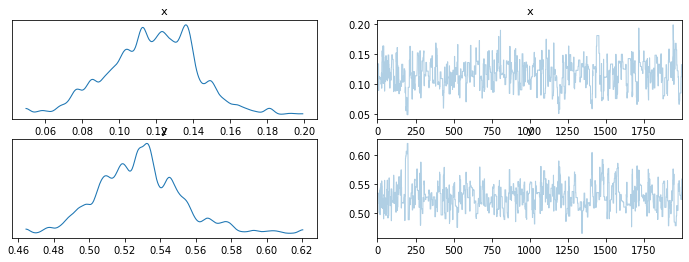

In [ ]:
string_ID = "overdispersed" 
trace_cir, x_stats_cir, y_stats_cir = (
     get_parameter_posteriors(string_ID, const, mx, data, ll_func=ll_CIR, draws_=2000, tune_=600, chains_=1) )

Plotting histograms in terms of (x,y)...


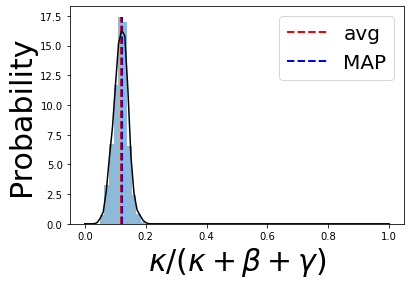

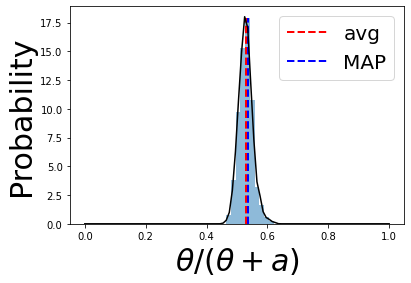

Plotting histograms in terms of (kappa, theta)...


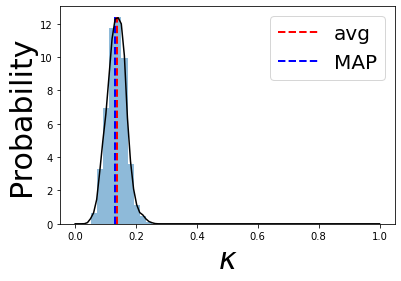

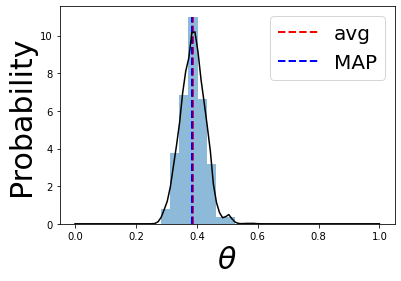

Plotting 2D heatmap in terms of (x, y)...


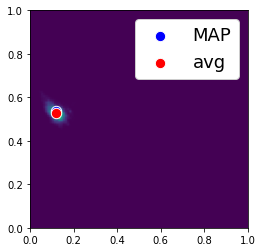

Plotting 2D heatmap in terms of (kappa, theta)...


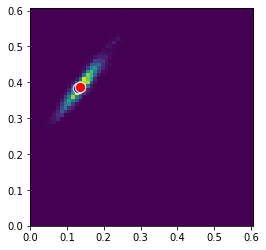

In [ ]:
loc = True
k_max = 1
th_max = 1
analyze_posteriors(string_ID, x_stats_cir, y_stats_cir, [], loc, k_max, th_max)

In [ ]:
a_cir, kappa_cir, theta_cir = convert_xy_to_params(x_stats_cir.mean(), y_stats_cir.mean(), beta, gamma, K_avg)

In [ ]:

params_cir = [beta, gamma, a_cir, kappa_cir, theta_cir]
Pss_cir = get_CIR_2sp(mx, params_cir)

In [ ]:
-np.log(Pss_cir[data]).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


18665.73725482444

we want likelihood/probability to be high... we want log-likelihood to be high... we want negative log likelihood to be low.

So if the negative log likelihood of CIR - negative log likelihood of GOU is negative, then the negative log likelihood of CIR is higher, then CIR is preferred.

In [ ]:
(-np.log(Pss_cir[data]).sum()) - (-np.log(Pss[data]).sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """Entry point for launching an IPython kernel.


-2627.261876091212

Then CIR is preferred by uhhhh

some amount...
-2627 seems excessive

In [ ]:
GOU_log_probability = np.zeros(len(x_stats))

for i in range(len(x_stats)):
    x = x_stats[i]
    y = y_stats[i]
    a, k, th = convert_xy_to_params(x, y , beta, gamma, K_avg)    
    params = [beta, gamma, a, k, th]
    Pss = get_GOU_2sp(mx, params)
    GOU_log_probability[i] = np.log(Pss[data]).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


In [ ]:
import scipy

In [ ]:
log_prob_GOU = scipy.special.logsumexp(GOU_log_probability)

In [ ]:
CIR_log_probability = np.zeros(len(x_stats_cir))

for i in range(len(x_stats_cir)):
    x = x_stats_cir[i]
    y = y_stats_cir[i]
    a, k, th = convert_xy_to_params(x, y , beta, gamma, K_avg)    
    params = [beta, gamma, a, k, th]
    Pss = get_CIR_2sp(mx, params)
    CIR_log_probability[i] = np.log(Pss[data]).sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':


In [ ]:
log_prob_CIR = scipy.special.logsumexp(CIR_log_probability)

In [ ]:
LOG_BAYES_FACTOR = log_prob_GOU - log_prob_CIR

In [ ]:
np.exp(LOG_BAYES_FACTOR)

2.6270505041349854e-09

it's aliiiiiiiiive
 omg
 